# Kaggle Titanic challenge solved with Tensorflow
Mainly for trying out feature parsing and representation capabilities of Tensorflow. The small amount of data makes a DNN not the best choice for a classifier.

In [19]:
# Some analysis on data set using pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def extract_title(name):
    title = name.split(",")[1].split(".")[0].strip()
    if title == 'Ms':
        return 'Miss'
    return title

df = pd.read_csv('train.csv', dtype={'Embarked': 'category', 'Sex': 'category'})
df['Title'] = df.apply (lambda row: extract_title(row['Name']),axis=1)
df_test = pd.read_csv('test.csv', dtype={'Embarked': 'category', 'Sex': 'category'})
df_test['Title'] = df_test.apply (lambda row: extract_title(row['Name']),axis=1)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs


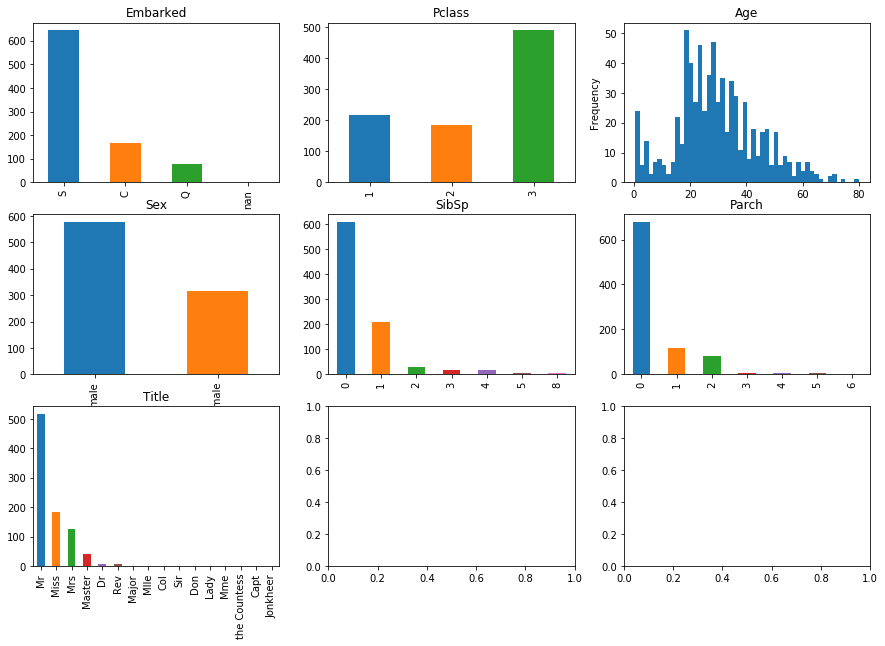

In [20]:
# Some histograms to get an idea of values present and their distribution
def make_plots(df):
    fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(15, 10))
    df['Embarked'].value_counts(dropna=False).plot(kind='bar', ax=axs[0, 0], title='Embarked'), 
    df['Pclass'].value_counts(dropna=False, sort=False).plot(kind='bar', ax=axs[0, 1], title='Pclass')
    df['Sex'].value_counts(dropna=False).plot(kind='bar', ax=axs[1, 0], title='Sex')
    df['SibSp'].value_counts(dropna=False, sort=False).plot(kind='bar', ax=axs[1, 1], title='SibSp')
    df['Parch'].value_counts(dropna=False, sort=False).plot(kind='bar', ax=axs[1, 2], title='Parch')
    df['Age'].plot.hist(ax=axs[0, 2], title='Age', bins=50) # Does not show NaN
    df['Title'].value_counts(dropna=False).plot(kind='bar', ax=axs[2, 0], title='Title'), 
    plt.show()
make_plots(df)

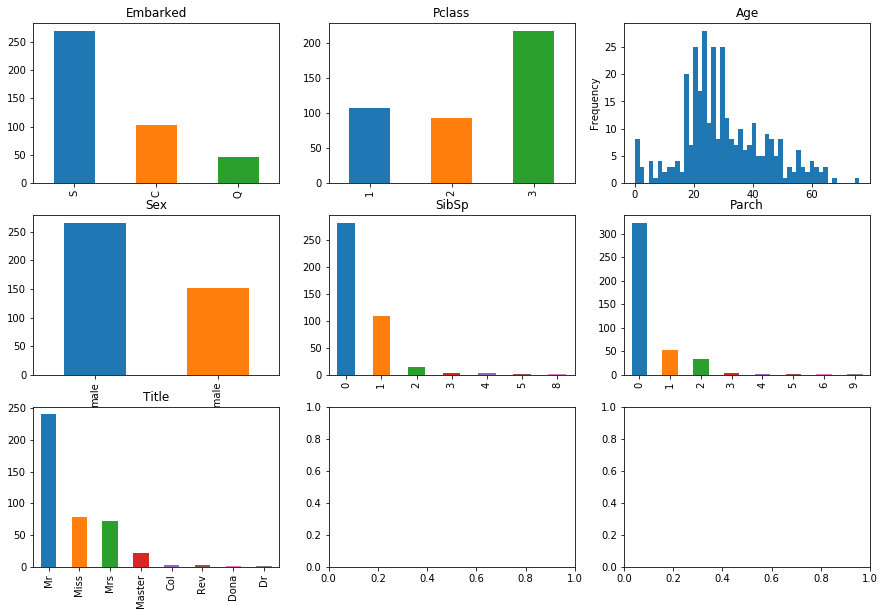

In [21]:
# Show also plots for test set to see if there are any big differences.
make_plots(df_test)

In [25]:
import tensorflow as tf

# Sets default age to -1.
_CSV_COLUMNS='PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked'.split(',')
_CSV_COLUMN_DEFAULTS = [[''], [0], [''], [''], [''], [-1.0], [-1], [-1], [''], [0.0], [''], ['']]

_CSV_COLUMNS_TEST='PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked'.split(',')
_CSV_COLUMN_DEFAULTS_TEST = [[''], [''], [''], [''], [-1.0], [-1], [-1], [''], [0.0], [''], ['']]

def make_input_fn(data_file, num_epochs, shuffle, batch_size, is_train=True):
    """Generate an input function for the Estimator."""
    assert tf.gfile.Exists(data_file), (
      '%s not found. Please make sure you have either run data_download.py or '
      'set both arguments --train_data and --test_data.' % data_file)
    def input_fn():
        def parse_csv(value):
            record_defaults = _CSV_COLUMN_DEFAULTS if is_train else _CSV_COLUMN_DEFAULTS_TEST
            columns = tf.decode_csv(value, record_defaults=record_defaults)
            headers = _CSV_COLUMNS if is_train else _CSV_COLUMNS_TEST
            features = dict(zip(headers, columns))
            # TODO(panmari): Use tensorflow string processing instead (complicated)
            features['Title'] = tf.py_func(lambda x: extract_title(str(x)), 
                                           [features['Name']], 
                                           tf.string,
                                           stateful=False)
            features['AgeNormed'] = features['Age'] / tf.constant(80.0) # Max in dataset is 80, as determined above.
            features['AgeLog'] = tf.log(features['Age'])
            features['FareLog'] = tf.log(features['Fare'] + 1)
            labels = features.pop('Survived') if is_train else tf.constant(0)
            return features, labels

        # Extract lines from input files using the Dataset API.
        dataset = tf.data.TextLineDataset(data_file).skip(1) # Skip header.
        if shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.map(parse_csv, num_parallel_calls=5)

        # We call repeat after shuffling, rather than before, to prevent separate
        # epochs from blending together.
        dataset = dataset.repeat(num_epochs)
        dataset = dataset.batch(batch_size)

        iterator = dataset.make_one_shot_iterator()
        features, labels = iterator.get_next()
        return features, labels
    return input_fn

In [23]:
# Implements various ways to represent features. See description at https://www.kaggle.com/c/titanic/data
passenger_id = tf.feature_column.numeric_column('PassengerId')
survived = tf.feature_column.numeric_column('Survived')
p_class =  tf.feature_column.categorical_column_with_vocabulary_list('Pclass', ['1', '2', '3'], num_oov_buckets=0)
p_class_embed = tf.feature_column.embedding_column(p_class, 1)
p_class_onehot = tf.feature_column.indicator_column(p_class)

name =  tf.feature_column.categorical_column_with_hash_bucket('Name', hash_bucket_size=1000)
name_embed = tf.feature_column.embedding_column(name, 16)

sex = tf.feature_column.categorical_column_with_vocabulary_list('Sex', ['male', 'female'], num_oov_buckets=0)
sex_embed = tf.feature_column.embedding_column(sex, 1)
sex_onehot = tf.feature_column.indicator_column(sex)

age = tf.feature_column.numeric_column('Age')
age_normed = tf.feature_column.numeric_column('AgeNormed')
age_log = tf.feature_column.numeric_column('AgeLog')
age_buckets = tf.feature_column.bucketized_column(age, [0.0, 1.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0])

fare = tf.feature_column.numeric_column('Fare')
fare_log = tf.feature_column.numeric_column('FareLog')

sib_sp = tf.feature_column.numeric_column('SibSp')
sib_sp_onehot = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_identity('SibSp', 9, default_value=8))
sib_sp_buckets = tf.feature_column.bucketized_column(sib_sp, [1, 2, 3, 4])
                                                     
parch = tf.feature_column.numeric_column('Parch')
parch_onehot = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_identity('Parch', 7, default_value=6))
parch_buckets = tf.feature_column.bucketized_column(parch, [1, 2, 3])

                                                                                                          
# Use most common value ('S') as default, as there's not enough data for missing value.
embarked = tf.feature_column.categorical_column_with_vocabulary_list('Embarked', ['C', 'Q', 'S'], 
                                                                     default_value=2)
embarked_embed = tf.feature_column.embedding_column(embarked, 1)
embarked_onehot = tf.feature_column.indicator_column(embarked)

title = tf.feature_column.categorical_column_with_vocabulary_list('Title', ['Mr', 'Mrs', 'Miss', 'Master'], 
                                                                  num_oov_buckets=1)
title_embed = tf.feature_column.embedding_column(title, 2)
title_onehot = tf.feature_column.indicator_column(title)

# Crossed columns
embarked_title = tf.feature_column.crossed_column([embarked, title], hash_bucket_size=10)

In [26]:
# Deep neural network for classification

run_config = tf.estimator.RunConfig().replace(save_summary_steps=5)

estimator = tf.estimator.DNNClassifier(
        model_dir="tf_model_32x16_evaluated_age_fare_family_buckets",
        feature_columns=[p_class_onehot, sex_onehot, age, fare,
                         sib_sp_buckets, parch_buckets, 
                         embarked_onehot, 
                         title_onehot],
        hidden_units=[32, 16],
        optimizer=tf.train.AdamOptimizer(),
        config=run_config)

estimator.train(input_fn=make_input_fn('train_shuf_rest.csv',
                                       num_epochs=200, shuffle=True, batch_size=128))

estimator.evaluate(input_fn=make_input_fn('train_shuf_head_100.csv', 
                                          num_epochs=1, shuffle=False, batch_size=1024))


INFO:tensorflow:Using config: {'_model_dir': 'tf_model_32x16_evaluated_age_fare_family_buckets', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8555ee7d30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_model_32x16_evaluated_age_fare_family_buckets/model.ckpt-8048
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoi

{'accuracy': 0.8484849,
 'accuracy_baseline': 0.56565654,
 'auc': 0.9335549,
 'auc_precision_recall': 0.91370857,
 'average_loss': 0.34141156,
 'global_step': 9286,
 'label/mean': 0.43434343,
 'loss': 33.799744,
 'prediction/mean': 0.41283047}

In [28]:
# Wide and deep (neural network & linear part) for classification.

run_config = tf.estimator.RunConfig().replace(save_summary_steps=5)

p_class_x_title = tf.feature_column.crossed_column([p_class, title], 10)
p_class_x_title_x_age_bucket =  tf.feature_column.crossed_column([p_class, title, age_buckets], 30)
p_class_x_title_x_parch_buckets =  tf.feature_column.crossed_column([p_class, title, parch_buckets], 30)
p_class_x_title_x_sib_sp_buckets = tf.feature_column.crossed_column([p_class, title, sib_sp_buckets], 30)

estimator = tf.estimator.DNNLinearCombinedClassifier(
        model_dir="tf_wide_and_deep_classXtitle_classXtitleXsib_classXtitleXagebucket_classXtitleXparchbuckets",
        linear_feature_columns=[ p_class, 
                                 sex,
                                 sib_sp_buckets, 
                                 parch_buckets, 
                                 embarked, 
                                 title, 
                                 p_class_x_sex,
                                 p_class_x_title_x_sib_sp_buckets,
                                 p_class_x_title_x_age_bucket,
                                 p_class_x_title_x_parch_buckets],
        dnn_feature_columns=[p_class_onehot, sex_onehot, age, fare,
                             sib_sp_buckets, parch_buckets, 
                             embarked_onehot, 
                             title_onehot],
        dnn_hidden_units=[32, 16],
        config=run_config)

estimator.train(input_fn=make_input_fn('train_shuf_rest.csv',
                                       num_epochs=400, shuffle=True, batch_size=256))

estimator.evaluate(input_fn=make_input_fn('train_shuf_head_100.csv', 
                                          num_epochs=1, shuffle=False, batch_size=1024))


INFO:tensorflow:Using config: {'_model_dir': 'tf_wide_and_deep_classXsex_classXsib_classXtitleXagebucket_classXtitleXparchbuckets', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f85b2bf6630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into tf_wide_and_deep_classXsex_classXsib_classXtitleXagebucke

{'accuracy': 0.8484849,
 'accuracy_baseline': 0.56565654,
 'auc': 0.87375414,
 'auc_precision_recall': 0.8901735,
 'average_loss': 0.43764758,
 'global_step': 1238,
 'label/mean': 0.43434343,
 'loss': 43.32711,
 'prediction/mean': 0.40801644}

In [29]:
# Run predictions on test set after running on full training set.
estimator.train(input_fn=make_input_fn('train.csv', num_epochs=400, shuffle=True, batch_size=256))

input_fn = make_input_fn('test.csv', num_epochs=1, shuffle=False, batch_size=1024, is_train=False)
results = estimator.predict(input_fn=input_fn)

sess = tf.Session()
features, labels = sess.run(input_fn())
with open('test_predictions.csv', 'w') as f:
    f.write('PassengerId,Survived\n')
    for pid, r in zip(features['PassengerId'], results):
        f.write(','.join([pid.decode("utf-8"), r['classes'][0].decode("utf-8")]) + '\n')


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wide_and_deep_classXsex_classXsib_classXtitleXagebucket_classXtitleXparchbuckets/model.ckpt-1238
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1239 into tf_wide_and_deep_classXsex_classXsib_classXtitleXagebucket_classXtitleXparchbuckets/model.ckpt.
INFO:tensorflow:loss = 107.37103, step = 1238
INFO:tensorflow:global_step/sec: 37.8443
INFO:tensorflow:loss = 110.40777, step = 1338 (2.643 sec)
INFO:tensorflow:global_step/sec: 50.2873
INFO:tensorflow:loss = 103.10298, step = 1438 (1.989 sec)
INFO:tensorflow:global_step/sec: 51.4087
INFO:tensorflow:loss = 105.60062, step = 1538 (1.945 sec)
INFO:tensorflow:global_step/sec: 50.0155
INFO:tensorflow:loss = 97.40303, step = 1638 (1.999 sec)
INFO:tensorflow:global_step/sec: 50

In [19]:
# Some code for debugging features
input_fn=make_input_fn('test.csv', num_epochs=1, shuffle=False, batch_size=1024, is_train=False)
features, label = input_fn()
sess = tf.Session()
sess.run(features['Title'])

RuntimeError: Graph is finalized and cannot be modified.